# Stats 2 Project 2
<i>Kito Patterson and Hayley Horn</i>

## Introduction

Home Equity loans are an alternative to credit card debt for home owners because it leverages a secured asset, and lower risk can mean a lower interest rate.  Home equity lines of credit account for approximately 4% of debt among consumers (1). While the lower interest rate may be a benefit, there are still many default on their home equity loans, which happens when a loan is 90+ days outstanding. The value of 90+ day delinquencies is 2.23B in 2016(2).  In this study we seek to uncover factors that contribute to these defaults so that we can predict an applicant’s propensity to default. This study dives into a collection of potential variables and delinquency indicator on home equity loans. Ideally, the information gleaned from this research can help identify risk factors prior to default and giving some chance for intervention.

In [2]:
import pandas as pd
import numpy as np 
import warnings

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

warnings.filterwarnings('ignore')

# All PACKAGES USED IN THIS NOTEBOOK
# import pandas as pd
# import numpy as np
# import warnings

# import matplotlib.pyplot as plt
# import seaborn as sns

# from patsy import dmatrices
# import statsmodel.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# from sklearn.utils import resample
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix


# Data import
df = pd.read_csv("hmeq.csv")

## Exploratory Data Analysis

In [3]:
# Get a quick summary of table structure
print("Number of Rows, Number of Columns:", df.shape)

Number of Rows, Number of Columns: (5960, 13)


First we will review a sample of the dataset to get an understating...

In [4]:
# View the first 5 rows
df.head() 

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


This dataset seems to have some missing values that need to be addressed before EDA. Lets take a look below.

In [5]:
# Get a view of data types withing the dataframe
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5960 non-null int64
LOAN       5960 non-null int64
MORTDUE    5442 non-null float64
VALUE      5848 non-null float64
REASON     5708 non-null object
JOB        5681 non-null object
YOJ        5445 non-null float64
DEROG      5252 non-null float64
DELINQ     5380 non-null float64
CLAGE      5652 non-null float64
NINQ       5450 non-null float64
CLNO       5738 non-null float64
DEBTINC    4693 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


Now lets take a closer look at the missing values by column.'DEBTINC' (Debt to Income ratio) is missing more than 20% of its values followed by 'DEROG' at 11%. That may be too many values to impute. We may want to impute values within groupings as a alternative. For example, 'DEBTINC' mean or median values may be significantly different for "Sales" vs "Other" job titles. We need to explore deeper to see if there is a story to uncover if we decide to impute.

In [6]:
# Missong values sort descending
df_percent = df.isna().sum()/len(df)*100 # Percent of total 'NaN' rows by column
df_percent.sort_values(ascending=False)

DEBTINC    21.258389
DEROG      11.879195
DELINQ      9.731544
MORTDUE     8.691275
YOJ         8.640940
NINQ        8.557047
CLAGE       5.167785
JOB         4.681208
REASON      4.228188
CLNO        3.724832
VALUE       1.879195
LOAN        0.000000
BAD         0.000000
dtype: float64

Before we address NaN values, let's address the "JOB" variable. The "Other" category accounts for 42% of the total dataset. This may be a good varible to drop from the analysis given it is a miscellaneous catch-all with no pratcial use. 

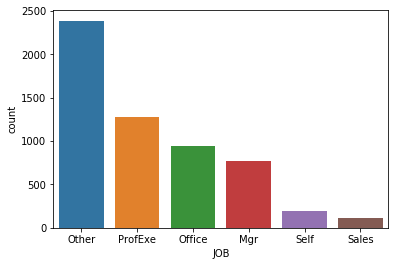

In [7]:
# Review composition of job type
import seaborn as sns 
order=["Other","ProfExe","Office","Mgr","Self","Sales"]

sns.countplot(x="JOB", order=order, data=df)

In [8]:
# get job counts by category and values
c2 = df.JOB.value_counts(dropna=True)
p2 = df.JOB.value_counts(dropna=True, normalize=True)

# concatenate both df's to create combined df
pd.concat([c2,round((p2 * 100),2)], axis=1, keys=['counts', 'percent (%)'])

,counts,percent (%)
Other,2388,42.03
ProfExe,1276,22.46
Office,948,16.69
Mgr,767,13.50
Self,193,3.40
Sales,109,1.92


In [9]:
# Drop JOB variable dataframe
df.drop(['JOB'], axis=1, inplace=True)

## Feature Engineering 

There may be value in creating a calculated variable that represents property equity. We will add this engineered feature to our dataframe in support of subsequent modeling efforts. 

In [10]:
# Created feature to get a sense of equity value for home
df['PROP_EQUITY'] = df['VALUE']-df['MORTDUE'] # Created feature to get a sense of equity value for home
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,PROP_EQUITY
0,1,1100,25860.0,39025.0,HomeImp,10.5,0.0,0.0,94.366667,1.0,9.0,NaN,13165.0
1,1,1300,70053.0,68400.0,HomeImp,7.0,0.0,2.0,121.833333,0.0,14.0,NaN,-1653.0
2,1,1500,13500.0,16700.0,HomeImp,4.0,0.0,0.0,149.466667,1.0,10.0,NaN,3200.0
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,3.0,0.0,0.0,93.333333,0.0,14.0,NaN,14200.0


Almost half of the dataset is lost if we remove all rows with at least 1 NaN value. That isn't necessarily a bad thing, but it is worth noting. Imputing variables may be an option at a later juncture. We will move forward by simply removing rows with missing values for now.

In [11]:
#Create new dataframe with NaN rows removed
df_NoNaN = df.dropna() 

# comparing NEW (df) vs OLD (df2) dataframes 
print("Old data frame length:", len(df), "\nNew data frame length:",  
       len(df_NoNaN), "\nNumber of rows with at least 1 NA value: ", 
       (len(df)-len(df_NoNaN)),"\nPercent of total rows lost to NA values:",
     (len(df)-len(df_NoNaN))/len(df))

Old data frame length: 5960 
New data frame length: 3445 
Number of rows with at least 1 NA value:  2515 
Percent of total rows lost to NA values: 0.42197986577181207


Now we will review the summary statistics after removing the incomplete records 

In [12]:
#Summary Statistics of complete data records
df_NoNaN.describe().T

,count,mean,std,min,25%,50%,75%,max
BAD,3445.0,0.087373,0.282422,0.000000,0.000000,0.000000,0.000000,1.000000
LOAN,3445.0,19241.451379,11391.553516,1700.000000,11900.000000,16900.000000,23700.000000,89900.000000
MORTDUE,3445.0,75932.253701,44879.113694,5076.000000,49232.000000,66823.000000,92789.000000,399412.000000
VALUE,3445.0,107161.347750,54274.878525,21144.000000,71303.000000,94247.000000,122273.000000,512650.000000
YOJ,3445.0,9.143687,7.630055,0.000000,3.000000,7.000000,14.000000,41.000000
DEROG,3445.0,0.146880,0.578275,0.000000,0.000000,0.000000,0.000000,10.000000
DELINQ,3445.0,0.274311,0.801743,0.000000,0.000000,0.000000,0.000000,10.000000
CLAGE,3445.0,180.251906,82.156300,0.486711,118.616134,175.555571,228.802007,1168.233561
NINQ,3445.0,1.033672,1.542289,0.000000,0.000000,1.000000,2.000000,13.000000
CLNO,3445.0,21.998839,9.364877,0.000000,16.000000,21.000000,27.000000,64.000000


Lets split the summary by the binary response variable to see the difference in summary statistics between paid and defaults. 

In [13]:
# Summary statistics for Paid loans
df_NoNaN[df_NoNaN['BAD']==0].drop('BAD', axis=1).describe().T 

,count,mean,std,min,25%,50%,75%,max
LOAN,3144.0,19353.975827,11433.778547,2300.000000,12000.000000,17000.000000,23900.000000,89900.000000
MORTDUE,3144.0,76099.437341,44207.458301,5076.000000,49358.000000,67310.500000,93095.500000,371003.000000
VALUE,3144.0,107540.343511,53191.720011,26140.000000,71790.250000,94720.000000,122291.250000,471827.000000
YOJ,3144.0,9.298346,7.707882,0.000000,3.000000,7.000000,14.000000,36.000000
DEROG,3144.0,0.100827,0.379660,0.000000,0.000000,0.000000,0.000000,3.000000
DELINQ,3144.0,0.206107,0.590098,0.000000,0.000000,0.000000,0.000000,4.000000
CLAGE,3144.0,183.091586,80.434495,0.486711,121.168730,179.112046,231.562278,649.747104
NINQ,3144.0,0.973919,1.443370,0.000000,0.000000,0.000000,1.000000,11.000000
CLNO,3144.0,21.969148,9.114746,3.000000,16.000000,21.000000,27.000000,56.000000
DEBTINC,3144.0,33.566023,6.520347,4.029951,29.195736,34.762285,38.768523,45.569843


In [14]:
# Summary statistics for Default loans
df_NoNaN[df_NoNaN['BAD']==1].drop('BAD', axis=1).describe().T 

,count,mean,std,min,25%,50%,75%,max
LOAN,301.0,18066.112957,10889.624167,1700.000000,10500.000000,16200.000000,21900.000000,77400.000000
MORTDUE,301.0,74185.990033,51423.462054,5900.000000,44992.000000,62351.000000,88236.000000,399412.000000
VALUE,301.0,103202.667774,64481.564438,21144.000000,66603.000000,86172.000000,122124.000000,512650.000000
YOJ,301.0,7.528239,6.560236,0.000000,3.000000,6.000000,11.000000,41.000000
DEROG,301.0,0.627907,1.440284,0.000000,0.000000,0.000000,1.000000,10.000000
DELINQ,301.0,0.986711,1.781335,0.000000,0.000000,0.000000,1.000000,10.000000
CLAGE,301.0,150.590931,93.476629,8.055265,94.782231,132.836758,188.504617,1168.233561
NINQ,301.0,1.657807,2.247780,0.000000,0.000000,1.000000,2.000000,13.000000
CLNO,301.0,22.308970,11.675368,0.000000,14.000000,21.000000,28.000000,64.000000
DEBTINC,301.0,39.664808,15.345451,0.838118,32.761084,38.211305,43.847544,144.189001


In [15]:
# Create dataframe for numeric values only
df_numeric = df_NoNaN._get_numeric_data()

In [16]:
#Review top 5 records of numeric values
df_numeric.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,PROP_EQUITY
5,1,1700,30548.0,40320.0,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,9772.0
7,1,1800,28502.0,43034.0,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894,14532.0
19,0,2300,102370.0,120953.0,2.0,0.0,0.0,90.992533,0.0,13.0,31.588503,18583.0
25,1,2400,34863.0,47471.0,12.0,0.0,0.0,70.491080,1.0,21.0,38.263601,12608.0
26,0,2400,98449.0,117195.0,4.0,0.0,0.0,93.811775,0.0,13.0,29.681827,18746.0


## Assumptions For Logistic Regression

The following are ther assumptions for Logistic Regression:
-  response variable is binary 
     - 1=Default / 0=Paid)
-  data are independent
     - We make this assumption based on the dataset
-  Assumption of absence of multicollinearity #handled with the matrix
     - See Scatterplot matrix below
-  Assumption of continuos independent variables being linearly related to the log odds
     - See log plot below for an example
-  Assumption of lack of outliers
     -Our data set of n=600 is covered under CLT

'DebtInc Log Odds Linear Plot'

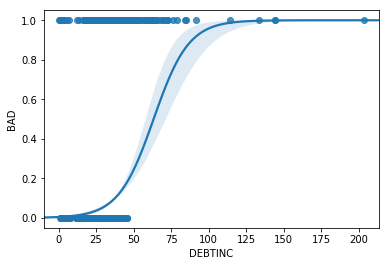

In [17]:
# DEBTINC is a good example of the independent varaible linearly related to logg odds 
df_debtinc = sns.regplot(x= 'DEBTINC', y= 'BAD', data= df, logistic= True).set_title
("DebtInc Log Odds Linear Plot")

None of the variables seem to show multicollinearity except "VALUE" and "MORTDUE". As home values increase so does the TOTAL mortgage due which would makes sense. We may not need both variables, but we will asses that in later modeling efforts.  

Text(0.5, 0.98, 'HMEQ Numeric Pairwise Plots')

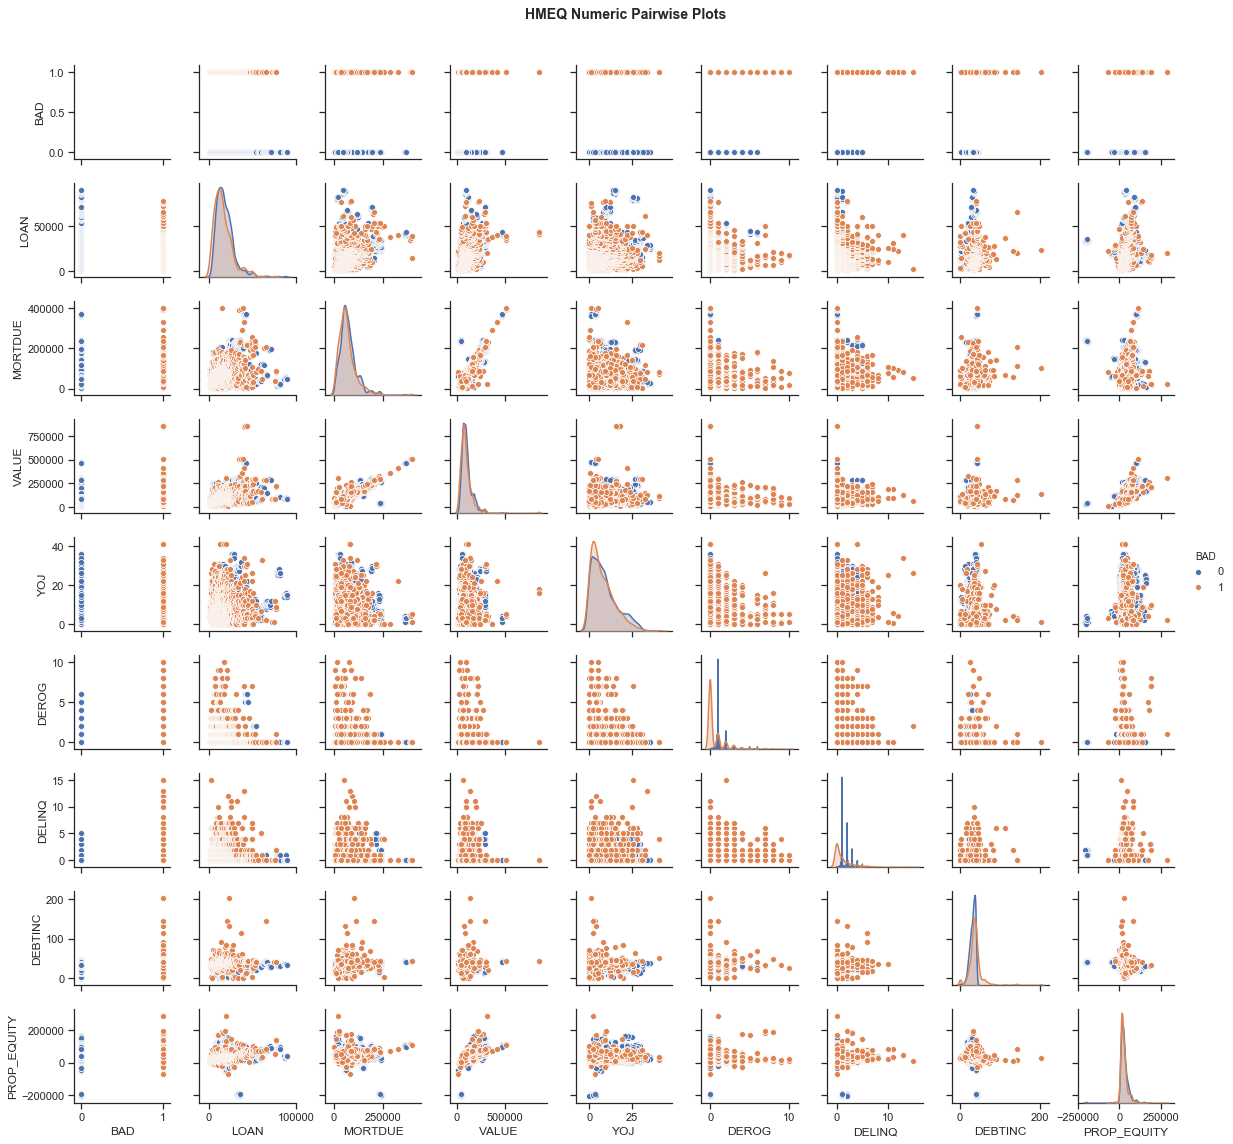

In [18]:
sns.set(style="ticks")

cols_cont = ['BAD','LOAN','MORTDUE','VALUE','YOJ',
             'DEROG','DELINQ','DEBTINC','PROP_EQUITY']

pp = sns.pairplot(df[cols_cont], 
                  height=1.8,
                  aspect=1.0,
                  hue="BAD")
fig = pp.fig
fig.subplots_adjust(top=0.93, wspace=0.3)
fig.suptitle('HMEQ Numeric Pairwise Plots', 
              fontsize=14, fontweight='bold')

### Heatmap

The heatmap shows 'VALUE' and 'MORTDUE' as the only variables at risk of mulitcollinearity.

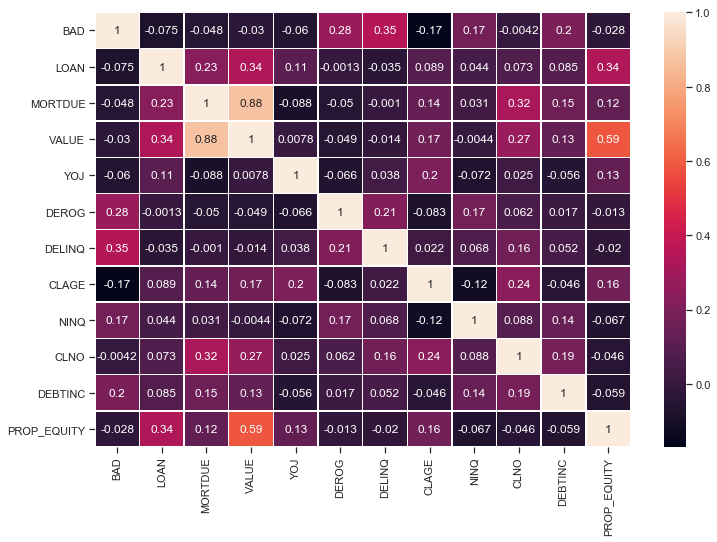

In [19]:
# Plot size of image
plt.figure(figsize=(12,8))

sns.heatmap(df.corr(), annot=True, linewidth=0.5)

### Variable Influence Factor (VIF)

Although the scatterplot matrix gives us a good visual of possible multicollinearity, VIF values gives us an additional measure to safe guard against collenearity amongst explanatory variables. As suspected, 'VALUE' and 'MORTDUE' are borderline, but they fall under the accetable threshold (VIF >5). In a attempt to reduce the amount of variables and complexities in our model, we will remove one of the two variables in support of subsequent modeling efforts. 'PROP_EQUITY' was not included in the VIF model given it is calculated from variables that are in the VIF table below.

In [20]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Break into left and right hand side; y and X
y, X = dmatrices(formula_like = "BAD ~ LOAN + MORTDUE + VALUE + YOJ + DEROG + DELINQ + CLAGE + NINQ + CLNO + DEBTINC", 
                 data = df_numeric, NA_action = "drop", return_type = "dataframe")

# For each Xi, calculate VIF
vif = pd.DataFrame()
vif['factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns

# Inspect VIF Factors
print("Variable Influence Factor (VIF)",vif)

Variable Influence Factor (VIF)        factor   features
0   29.315073  Intercept
1    1.222540       LOAN
2    4.598560    MORTDUE
3    4.668187      VALUE
4    1.109448        YOJ
5    1.066764      DEROG
6    1.048747     DELINQ
7    1.162751      CLAGE
8    1.072957       NINQ
9    1.221329       CLNO
10   1.094438    DEBTINC


We will remove the 'VALUE' variable given it is has a VIF closest to 5. This will allow us to reduce model complexity as much as possible before our model/feature selection efforts. 

In [21]:
# Drop VALUE variable dataframe
df_NoNaN.drop(['VALUE'], axis=1, inplace=True)

In [22]:
# Review dataframe to ensure variable was dropped
df_NoNaN.head()

,BAD,LOAN,MORTDUE,REASON,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,PROP_EQUITY
5,1,1700,30548.0,HomeImp,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,9772.0
7,1,1800,28502.0,HomeImp,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894,14532.0
19,0,2300,102370.0,HomeImp,2.0,0.0,0.0,90.992533,0.0,13.0,31.588503,18583.0
25,1,2400,34863.0,HomeImp,12.0,0.0,0.0,70.491080,1.0,21.0,38.263601,12608.0
26,0,2400,98449.0,HomeImp,4.0,0.0,0.0,93.811775,0.0,13.0,29.681827,18746.0


## Analysis

The response variable is severly imbalanced (91%/9%). We will need to address before modeling.

Text(0.5, 1.0, 'Default Counts Yes/No')

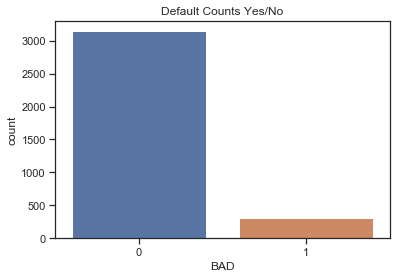

In [23]:
# response varaible proportion 
sns.countplot(x="BAD",data=df_NoNaN).set_title('Default Counts Yes/No')

In [24]:
# Response variable counts
c = df_NoNaN.BAD.value_counts(dropna=True)
p = df_NoNaN.BAD.value_counts(dropna=True, normalize=True)

# concatenate both df's to create combined df
pd.concat([c,round((p * 100),2)], axis=1, keys=['counts', 'percent (%)']) 

,counts,percent (%)
0,3144,91.26
1,301,8.74


Most borrowers are using their property equity to consolidate debt 

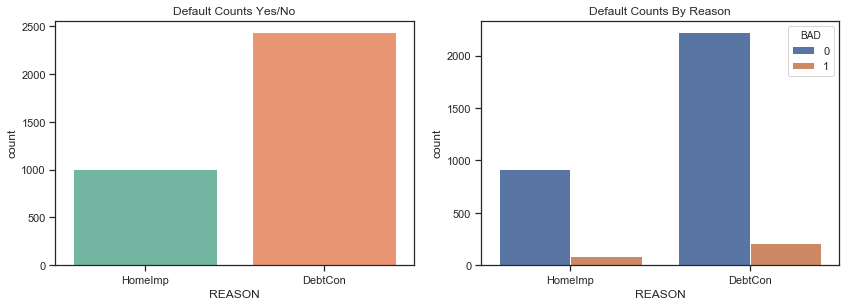

In [25]:
plt.figure(figsize=(12,8))

# Reason proportion 
plt.subplot(221)
sns.countplot(x="REASON",data=df_NoNaN, palette="Set2").set_title('Default Counts Yes/No')

# Reason proportion by default
plt.subplot(222)
sns.countplot(x="REASON", hue="BAD", data=df_NoNaN).set_title('Default Counts By Reason')

plt.tight_layout()

Borrowers who default tend to have slighty less years on the job than borrowers who don't default. They are likely less established with lower salaries that may signal more defaults. There also seems to be some seperation between both response populations and "CLAGE" (Age of oldest tradeline in # of months). This could indicate that less credit history can potentially lead to higher defaults. It is important to note the mean for defaults are skewed by a few outliers. We may need to investigate those observations further.

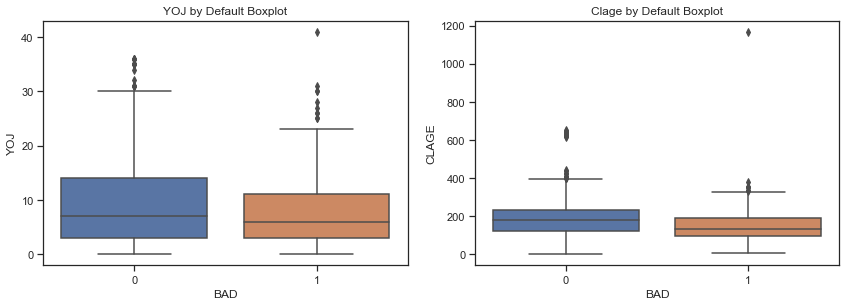

In [26]:
plt.figure(figsize=(12,8))

# YOJ by Default Boxplot
plt.subplot(221)
sns.boxplot(x="BAD", y="YOJ", data=df_NoNaN).set_title('YOJ by Default Boxplot')

# CLAGE by Default Boxplot
plt.subplot(222)
sns.boxplot(x="BAD", y="CLAGE", data=df_NoNaN).set_title('Clage by Default Boxplot')

plt.tight_layout()

There seems to be a good deal of interaction between the factor levels. 
This may suggest subsequent models may perform better with interaction terms included.

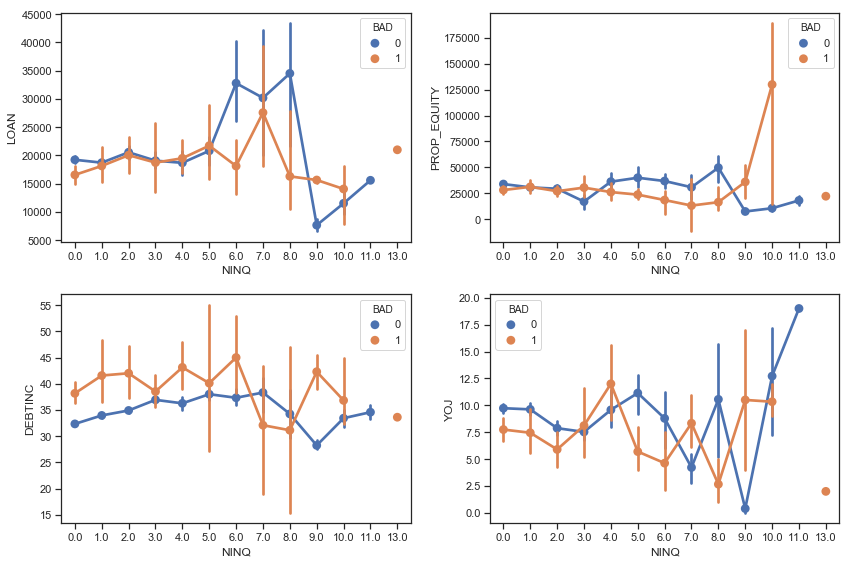

In [27]:
# View possible interactions of features
plt.figure(figsize=(12,8))

plt.subplot(221)
sns.pointplot(x="NINQ", y="LOAN", hue="BAD", data=df_NoNaN)

plt.subplot(222)
sns.pointplot(x="NINQ", y="PROP_EQUITY", hue="BAD", data=df_NoNaN)

plt.subplot(223)
sns.pointplot(x="NINQ", y="DEBTINC", hue="BAD", data=df_NoNaN)

plt.subplot(224)
sns.pointplot(x="NINQ", y="YOJ", hue="BAD", data=df_NoNaN)

plt.tight_layout()

## Data Preparation 

Remember we mentioned above, our dataset is extremely imbalanced with a 91/9 split for our binary outcome varaible. This imbalance can lead to predicting the majorty class (0) while compeletly ignoring the minority class outcomes (1). We decided to use the "resample" library in sklearn to down-sample our majority class without replacement. The imblance is too great to justify up-sampling. We will move forward with 602 total records. 

In [28]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df_NoNaN[df_NoNaN.BAD==0]
df_minority = df_NoNaN[df_NoNaN.BAD==1]
 
# Upsample minority class
df_majority_down_sample = resample(df_majority, 
                                 replace=False,     # sample without replacement
                                 n_samples=301,    # to match minority class
                                 random_state=7) # reproducible results
 
# Combine majority class with upsampled minority class
df_down_sample = pd.concat([df_majority_down_sample, df_minority])

# Display new class counts
df_down_sample.BAD.value_counts()

1    301
0    301
Name: BAD, dtype: int64

Let's transform the 'REASON' character variable into a indicator variable in preparation for subsequrent modeling. 

In [29]:
# Create dummy variables and drop the baseline dummy
df_dummies = pd.get_dummies(df_down_sample, columns=['REASON'], drop_first=True)

In [30]:
# Check to ensure dummy variables were created.
# Data needs to be shufffled in random order so that it is not sorted by the response variable.
from sklearn.utils import shuffle
df_dummies = shuffle(df_dummies) #shuffle dataframe after down sampling method


df_dummies.head(10)

,BAD,LOAN,MORTDUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,PROP_EQUITY,REASON_HomeImp
3553,0,18700,47903.0,3.0,0.0,0.0,120.418042,1.0,17.0,32.977597,16030.0,1
2380,0,14300,52608.0,0.0,0.0,0.0,217.277192,0.0,9.0,34.095384,24328.0,0
5342,1,30200,80951.0,19.0,4.0,0.0,130.360362,0.0,58.0,50.352999,35209.0,0
216,1,5200,40564.0,0.0,0.0,0.0,157.771036,1.0,13.0,72.670433,-1037.0,1
706,1,8100,28523.0,5.0,0.0,0.0,130.643933,0.0,16.0,37.393526,11293.0,0
3910,1,20500,113963.0,3.0,1.0,0.0,243.680604,1.0,26.0,143.949605,17172.0,1
148,0,5000,90059.0,7.0,0.0,0.0,193.636447,0.0,28.0,25.897316,23655.0,1
5268,1,28700,25190.0,1.0,0.0,1.0,201.176783,0.0,11.0,35.729287,34651.0,0
5591,1,36800,125894.0,11.0,0.0,1.0,214.731160,1.0,33.0,43.847544,46290.0,0
5620,0,38100,67559.0,16.0,0.0,0.0,190.676671,0.0,22.0,40.239610,45465.0,0


In [31]:
# Packages needed for modeling 
import statsmodels.api as sm
import sklearn as sl
import scipy as sci

Our dataset consist of values on different scales. We do not want our prediction model giving higher importance to variables just because they aren't scaled. The RobustScaler will standardize all continuous varaibles except the indicator and response variables. This particular scaler is robust to outliers and uses the formula below to scale the explanatory variables.

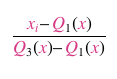

In [32]:
# Scale continuous variables except response and dummy variables. <br> 
# Interpretation of coefficients may be difficult as a result

#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# scaler = preprocessing.StandardScaler()
#scaler = MinMaxScaler()
scaler = RobustScaler()


# Standardize everything EXCEPT the indicatior variables
df_dummies[['LOAN','MORTDUE','YOJ',
            'DEROG','DELINQ',
            'CLAGE','NINQ',
            'CLNO','DEBTINC','PROP_EQUITY']] = scaler.fit_transform(df_dummies[['LOAN','MORTDUE','YOJ',
                                                                  'DEROG','DELINQ',
                                                                  'CLAGE','NINQ',
                                                                  'CLNO','DEBTINC','PROP_EQUITY']])

df_dummies.head()

,BAD,LOAN,MORTDUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,PROP_EQUITY,REASON_HomeImp
3553,0,0.188034,-0.399741,-0.4,0.0,0.0,-0.353857,0.0,-0.307692,-0.358445,-0.455141,1
2380,0,-0.188034,-0.292921,-0.7,0.0,0.0,0.531345,-0.5,-0.923077,-0.240495,-0.081500,0
5342,1,1.170940,0.350565,1.2,4.0,0.0,-0.262994,-0.5,2.846154,1.475019,0.408447,0
216,1,-0.965812,-0.566362,-0.7,0.0,0.0,-0.012486,0.0,-0.615385,3.829971,-1.223631,1
706,1,-0.717949,-0.839736,-0.2,0.0,0.0,-0.260402,-0.5,-0.384615,0.107527,-0.668438,0


## Modeling

First, we will fit a simple model with all explanatory variables to get a idea of predictive baseline performance. PROP_EQUITY will be used for more complex modeling later. The initial model will only consist of original variables except 'VALUE' and 'JOBS', which were dropped earlier. 

In [33]:
# Create target and feature variables
features = ['LOAN','MORTDUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC',
           'REASON_HomeImp']

X = sm.add_constant(df_dummies[features]) # Add features with intercept
#X2 = df_dummies[features] # Add features without intercept
y = df_dummies['BAD'] # Target (LABELS)

#X, y = dmatrices('BAD ~ LOAN + YOJ + NINQ + PROP_EQUITY')

In [34]:
from sklearn.model_selection import train_test_split

# 70/20 training/test split. random_state equivalent to set.seed in R
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

### Peformance Metrics

The illustration below explains the values of a confusion matrix and some performance metrics that we will use to evaluate our models.

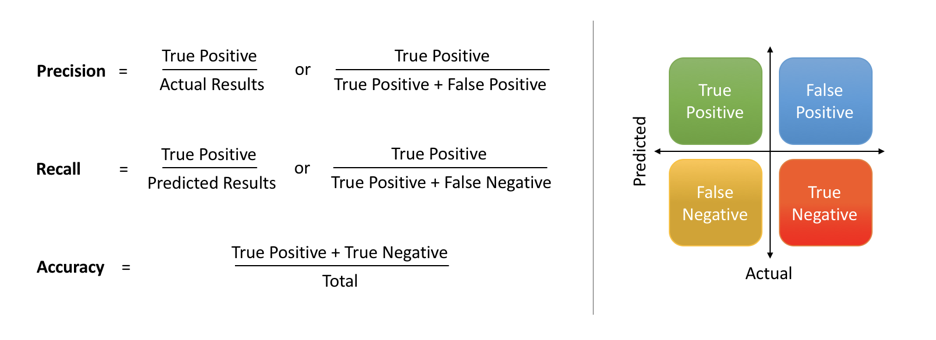

To plot a confusion matrix with Sklearn, a chunk of function code is needed which will be used for all of our models. Using the same evaluation methology despite using 2 different statistics packages (statsmodel and sklearn) for functions helps us compare the models consistently.  Statsmodel has the ability to output information that is important for interpretation, such as confidence intervals. Sklearn has more functionality for predictions, which is why it is a popular package for kaggle competitions.

## Function to plot confusion matrix

In [35]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
   
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('binary')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

### Logistic Regression (Baseline)

In [37]:
lr = sm.Logit(y_train, X_train)
lr_model = lr.fit()
lr_pred=lr_model.predict(X_test)
print("Baseline Model Summary",lr_model.summary())


Optimization terminated successfully.
         Current function value: 0.514955
         Iterations 7
Baseline Model Summary                            Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                  481
Model:                          Logit   Df Residuals:                      470
Method:                           MLE   Df Model:                           10
Date:                Sun, 21 Apr 2019   Pseudo R-squ.:                  0.2570
Time:                        08:45:22   Log-Likelihood:                -247.69
converged:                       True   LL-Null:                       -333.38
                                        LLR p-value:                 1.444e-31
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.4802      0.148     -3.249      0.001      -0.770      -

#### Outliers

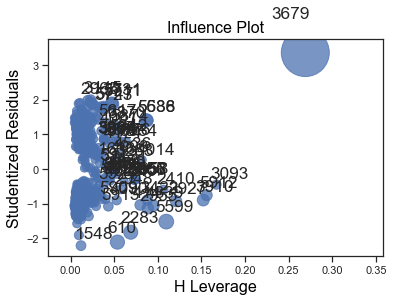

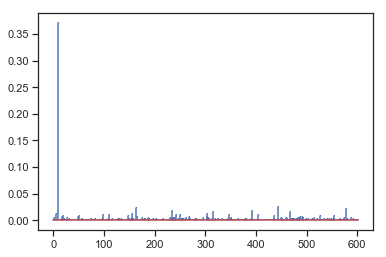

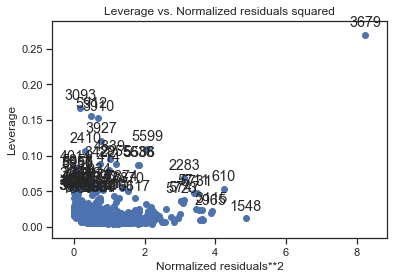

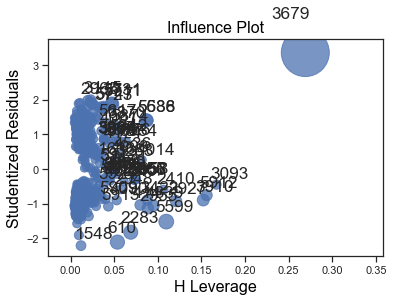

In [38]:
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.regressionplots import *


# Build and fit Ordinary Least Squares model
model = ols("BAD ~ LOAN + MORTDUE + YOJ + DEROG + DELINQ + CLAGE + NINQ + CLNO + DEBTINC + REASON_HomeImp", data=df_dummies)
model_fit = model.fit()

#plt.figure(figsize=(12,8))

#c is the distance and p is p-value
influence = model_fit.get_influence()
(c, p) = influence.cooks_distance
plt.stem(np.arange(len(c)), c, markerfmt=",")

#from statsmodels.graphics.regressionplots import *
plot_leverage_resid2(model_fit)
influence_plot(model_fit)

In [ ]:
# Investifate index #3679
df_dummies.loc[3679,:]

In [ ]:
# drop index row # 3679 from dataframe
df_dummies.drop(axis=0,index=3679,inplace=True)

#### Baseline Model Interpretation

A 1 unit increase or decrease in a variable affects the odds of defaulting. For example, 1 unit increase in 'LOAN' would account for a 87% increase in the odds of defaulting.

In [41]:
# Confidence Intervals and Odds Ratio
#Take the exponential of each of the coefficients to generate the odds ratios. 

params = lr_model.params
conf = lr_model.conf_int()
conf['OR'] = params
conf['p-value'] = lr_model.pvalues
conf.columns = ['CI Low 2.5%', 'CI High 97.5%', 'Odds Ratio','p-value']
print(np.exp(conf)-1)

#Use the Odds Ration to describe how a 1 unit increase/decrease in a variable affects the odds of defaulting.

                CI Low 2.5%  CI High 97.5%  Odds Ratio       p-value
const             -0.536897      -0.173452   -0.381310  1.158866e-03
LOAN              -0.329657       0.081792   -0.148429  2.070353e-01
MORTDUE           -0.127860       0.323976    0.074566  6.478506e-01
YOJ               -0.465127       0.009230   -0.265282  5.866570e-02
DEROG              0.651585       3.183151    1.628465  4.576057e-05
DELINQ             0.867978       2.814288    1.669271  7.007542e-08
CLAGE             -0.610886      -0.225967   -0.451195  6.266511e-04
NINQ               0.117742       1.019912    0.502578  7.014401e-03
CLNO              -0.502466      -0.060959   -0.316476  1.904822e-02
DEBTINC            0.386481       1.335354    0.799423  1.002365e-05
REASON_HomeImp    -0.350327       0.656584    0.037419  1.405444e+00


#### Prediction 

In [ ]:
# This code runs the confusion matric and ROC plot

import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score,accuracy_score

plt.figure(figsize=(12,8))

#change the lr_pred from series to array
lr_pred = pd.Series(lr_pred).values
lr_pred = lr_pred.round()

#Confusion Matrix
cmLR = confusion_matrix(lr_pred, y_test)

#Plot the confustion matrix
plot_confusion_matrix(cm           = cmLR, 
                      normalize    = True,
                      target_names = ['Paid', 'Default'],
                      title        = "Baseline Confusion Matrix, Normalized")

#Computing false and true positive rates
lr_fpr, lr_tpr,_=roc_curve(lr_pred, y_test,drop_intermediate=False)
# lr_roc_auc= metrics.auc(lr_fpr, lr_tpr)

##Adding the ROC
plt.plot(lr_fpr, lr_tpr, color='blue', 
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Baseline ROC curve')
plt.show() 

roc_auc_score
# predict probabilities
probs = (lr_pred > 0.5) #this is unique to stats model


plt.tight_layout()

# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)

print("LR Accuracy",accuracy_score(y_test, lr_pred))
print("LR Precision",precision_score(y_test, lr_pred, average='weighted'))
print("LR Sensitivity",(cmLR[1,1]/float(cmLR[1,1]+cmLR[1,0])))
print("LR Specificity",(cmLR[0,0]/float(cmLR[0,0]+cmLR[0,1])))

### LASSO Regression

The LASSO Regression model did its job as a feature reduction tool. 'MORTDUE' and 'REASON_HomeImp' were removed as their coefficients were changed to zero. 

In [ ]:
lasso_model=sm.Logit(y_train, X_train)

N = len(y_train)
K = X_train.shape[1]
alpha = 0.01 * N * np.ones(K)

ls_result=lasso_model.fit_regularized(method='l1', alpha=alpha, refit=True)
print(ls_result.summary())

Forward, Backward and stepwise modeling selection techniques require that you have some semblenace of variable order and importance. Given this isn't our domain expertise, and to reduce the amount of steps, we've opted for a Lasso regression model. We also chose LASSO Regression because it is a good feature reduction tool that allows us to reduce model comlexity. Controlled by L1 regularization and alpha, an additional coeeficient converged until it become zero (REASON), therby removing it from our model.

In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score

#Optimizing logistic function with L1 penalty (LASSO)
lasso = LogisticRegression(penalty='l1', solver='liblinear')
lasso_model = lasso.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

#Confusion Matrix
cmLASSO = confusion_matrix(lasso_pred, y_test)

#Plot the confusion matrix
plot_confusion_matrix(cm           = cmLASSO, 
                      normalize    = True,
                      target_names = ['Paid', 'Default'],
                      title        = "Lasso Confusion Matrix, Normalized")

#Computing false and true positive rates
lasso_fpr, lasso_tpr,_=roc_curve(lasso_pred, y_test,drop_intermediate=False)
# lasso_roc_auc= metrics.auc(lasso_fpr, lasso_tpr)

##Adding the ROC
plt.plot(lasso_fpr, lasso_tpr, color='darkred',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Lasso ROC curve')
plt.show()

roc_auc_score
# predict probabilities
probs = lasso.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)


print('AUC: %.3f' % auc)

print("LASSO Accuracy",accuracy_score(y_test, lasso_pred))
print("LASSO Precision",precision_score(y_test, lasso_pred, average='weighted'))
print("LASSO Sensitivity",(cmLASSO[1,1]/float(cmLASSO[1,1]+cmLASSO[1,0])))
print("LASSO Specificity",(cmLASSO[0,0]/float(cmLASSO[0,0]+cmLASSO[0,1])))

### Random Forest

We chose Random forest for our next model, as it a supervised learning algorithm that is flexible and commonly used for classification and feature selection.

A random forest is comprised of decision trees, which are created on ransomly selected samples within the dataset. It iterates through the sample, calculating predictions for each tree and identifies the best solution.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score

rf = RandomForestClassifier(n_estimators=60)
rf_model = rf.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

#Confusion Matrix
cmRF = confusion_matrix(rf_pred, y_test)

#Plot the confustion matrix
plot_confusion_matrix(cm           = cmRF, 
                      normalize    = True,
                      target_names = ['Paid', 'Default'],
                      title        = "Random Forest Confusion Matrix, Normalized")

#Computing false and true positive rates
rf_fpr, rf_tpr,_=roc_curve(rf_pred, y_test,drop_intermediate=False)
# rf_roc_auc= metrics.auc(rf_fpr, rf_tpr)

#plot the ROC/AUC
plt.figure()
##Adding the ROC
plt.plot(rf_fpr, rf_tpr, color='Green',
 lw=2, label='Random Forest ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

roc_auc_score
# predict probabilities
probs = rf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)


print("RF Accuracy",accuracy_score(y_test, rf_pred))
print("RF Precision",precision_score(y_test, rf_pred, average='weighted'))
print("RF Sensitivity",(cmRF[1,1]/float(cmRF[1,1]+cmRF[1,0])))
print("RF Specificity",(cmRF[0,0]/float(cmRF[0,0]+cmRF[0,1])))

## Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis, which is closely related to Quadratic Discriminant Analysis that classify based on a linear and a quadratic combination of features that separates two or more classes of objects or events. Both models have minimal tuning parameters and can work well when there is seperation in the data. Our data has a good amount of overlap, so there was concern that it would be a more challenging model in our dataset.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(X_train, y_train)
lda_pred=lda_model.predict(X_test)

#Confusion Matrix
cmLDA = confusion_matrix(lda_pred, y_test)

#Plot the confustion matrix
plot_confusion_matrix(cm           = cmLDA, 
                      normalize    = True,
                      target_names = ['Paid', 'Default'],
                      title        = "LDA Confusion Matrix, Normalized")

#Computing false and true positive rates
lda_fpr, lda_tpr,_=roc_curve(lda_pred, y_test,drop_intermediate=False)
# lda_roc_auc= metrics.auc(lda_fpr, lda_tpr)
                  
# Adding the ROC
plt.plot(lda_fpr, lda_tpr, color='grey',
  lw=2, label='ROC curve')
#Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
#Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('LDA ROC curve')
plt.show()
roc_auc_score
 # predict probabilities
probs = lda.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
#calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)

print("LDA Accuracy",accuracy_score(y_test, lda_pred))
print("LDA Precision",precision_score(y_test, lda_pred, average='weighted'))
print("LDA Sensitivity",(cmLDA[1,1]/float(cmLDA[1,1]+cmLDA[1,0])))
print("LDA Specificity",(cmLDA[0,0]/float(cmLDA[0,0]+cmLDA[0,1])))

# Suppress Warning
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

## K Nearest Neighbors (KNN)

The K nearest neighbors (KNN) model is a non-parametric method that can be used for both classification and regression. We designated to look at the features associated with the nearest 5 nieghbors to determine classification. 

In [ ]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 6 )
knn_model = knn.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

#Confusion Matrix
cmKNN = confusion_matrix(knn_pred, y_test)

#Plot the confusion matrix
plot_confusion_matrix(cm           = cmKNN, 
                      normalize    = True,
                      target_names = ['Paid', 'Default'],
                      title        = "KNN Confusion Matrix, Normalized")

##Computing false and true positive rates
knn_fpr, knn_tpr,_=roc_curve(knn_pred, y_test,drop_intermediate=False)
# knn_roc_auc= metrics.auc(knn_fpr, knn_tpr)

import matplotlib.pyplot as plt
plt.figure()
##Adding the ROC
plt.plot(knn_fpr, knn_tpr, color='darkorange',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('KNN ROC curve')
plt.show()

roc_auc_score
# predict probabilities
probs = knn.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)

print("KNN Accuracy",accuracy_score(y_test, knn_pred))
print("KNN Precision",precision_score(y_test, knn_pred, average='weighted'))
print("KNN Sensitivity",(cmKNN[1,1]/float(cmKNN[1,1]+cmKNN[1,0])))
print("KNN Specificity",(cmKNN[0,0]/float(cmKNN[0,0]+cmKNN[0,1])))

### Logistic Regression (Complex)

The VALUE variable was eliminated earlier, but we thought there may value in creating a calculated variable that represents property equity. We will add this engineered feature to our dataframe and remove MORTDUE and REASON based on our LASSO Regression model.

In [ ]:
# Create target and feature variables
features2 = ['LOAN','MORTDUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC',
           'PROP_EQUITY']

X2 = sm.add_constant(df_dummies[features2]) # Add features with intercept
#X2 = df_dummies[features] # Add features without intercept
y = df_dummies['BAD'] # Target (LABELS)

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.20, random_state=7)

lrc = LogisticRegression()
lrc_model = lrc.fit(X_train, y_train)
lrc_pred = lrc_model.predict(X_test)

#Confusion Matrix
cmLRC = confusion_matrix(lrc_pred, y_test)

#Plot the confusion matrix
plot_confusion_matrix(cm           = cmLRC, 
                      normalize    = True,
                      target_names = ['Paid', 'Default'],
                      title        = "Logistic Regression Complex Confusion Matrix, Normalized")

##Computing false and true positive rates
lrc_fpr, lrc_tpr,_=roc_curve(lrc_pred, y_test,drop_intermediate=False)
# lrc_roc_auc= metrics.auc(lrc_fpr, lrc_tpr)

import matplotlib.pyplot as plt
plt.figure()
##Adding the ROC
plt.plot(lrc_fpr, lrc_tpr, color='pink',
 lw=2, label='Logistic Regression Complex ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

roc_auc_score
# predict probabilities
probs = lrc.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)

print("LRC Accuracy",accuracy_score(y_test, lrc_pred))
print("LRC Precision",precision_score(y_test, lrc_pred, average='weighted'))
print("LRC Sensitivity",(cmLRC[1,1]/float(cmLRC[1,1]+cmLRC[1,0])))
print("LRC Specificity",(cmLRC[0,0]/float(cmLRC[0,0]+cmLRC[0,1])))

### ROC/AUC Comparisons

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(rf_fpr, rf_tpr, color='Green',
         lw=2, label='Random Forest (area = %0.2f)')
plt.plot(knn_fpr, knn_tpr, color='darkorange',
         lw=2, label='K-nearest Neighbours (area = %0.2f)')
plt.plot(lr_fpr, lr_tpr, color='blue', 
         lw=2, label='Base Regression (area = %0.2f)')
plt.plot(lasso_fpr, lasso_tpr, color='darkred',
         lw=2, label='Lasso Neighbours (area = %0.2f)')
plt.plot(lda_fpr, lda_tpr, color='grey',
         lw=2, label='LDA Regression (area = %0.2f)')
plt.plot(lrc_fpr, lrc_tpr, color='pink',
         lw=2, label='LRC Regression (area = %0.2f)')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparing the ROC Curve and AUC for Six Models')
plt.legend(loc="lower right")
